In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import time 
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
from collections import Counter
import zipfile
import gzip
import nltk 
import re
from string import punctuation
import random
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
class DownloadProgress(tqdm):
    last_block = 0
    
    def update_hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [0]:
dataset_file_name = 'reviews_Health_and_Personal_Care_5.json.gz'
data_folder_path = 'data'
dataset_desc_name = 'Amazon Reviews'
dataset_url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Health_and_Personal_Care_5.json.gz'

if not isfile(dataset_file_name):
    with DownloadProgress(unit='B', miniters=1, unit_scale=True, desc=dataset_desc_name) as download_progress:
        urlretrieve(dataset_url,dataset_file_name, download_progress.update_hook)

In [0]:
def read_raw_data():
    with gzip.open(dataset_file_name, 'rb') as file:
        raw_data = pd.read_json(file, lines=True)
        return raw_data

In [5]:
raw_data = read_raw_data()
print(raw_data.shape)
print(raw_data.head())

(346355, 9)
         asin   helpful  ...                                summary unixReviewTime
0  159985130X    [1, 1]  ...                    Handy little gadget     1294185600
1  159985130X    [1, 1]  ...  Small & may need to encourage battery     1329523200
2  159985130X  [75, 77]  ...                Very good but not great     1275955200
3  159985130X  [56, 60]  ...           great addition to your purse     1202428800
4  159985130X    [1, 1]  ...              Very nice and convenient.     1313452800

[5 rows x 9 columns]


In [6]:
raw_corpus = "".join(raw_data['reviewText'])
print(len(raw_corpus))
print(type(raw_corpus))
print(raw_corpus[:300])


178234918
<class 'str'>
This is a great little gadget to have around.  We've already used it to look for splinters and a few other uses.  The light is great.  It's a handy size.  However, I do wish I'd bought one with a little higher magnification.I would recommend this for a travel magnifier for the occasional reading.I h


In [0]:
def tokenize_sentence(corpus):
    plunkt_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = plunkt_tokenizer.tokenize(corpus) 
    return raw_sentences

In [8]:
raw_sentences = tokenize_sentence(raw_corpus)
print('The number of sentences is {}'.format(len(raw_sentences)))

The number of sentences is 1520443


In [0]:
def clean_and_tokenize_words(raw_sentence, stops):
    special_chars = re.compile("[^A-Za-z]+")
    raw_sentence = re.sub(special_chars," ", raw_sentence)
    raw_sentence = ''.join([c for c in raw_sentence if c not in punctuation])
    raw_sentence = ' '.join(word for word in raw_sentence.split() if word not in stops)
    split_words = raw_sentence.split()
    return split_words

In [0]:
def create_vocab(sentences):
    all_words = []
    stops = stopwords.words('english')
    for sentence in tqdm(sentences):
        [all_words.append(word) for word in clean_and_tokenize_words(sentence, stops)]
    return all_words

In [11]:
vocab = create_vocab(raw_sentences)
print(len(vocab))
print(len(set(vocab)))

100%|██████████| 1520443/1520443 [01:24<00:00, 17996.12it/s]


18607500
178524


In [0]:
vocab_size = 50000
count = [('UNK', -1)]
# get the most common words
count.extend(Counter(vocab).most_common(vocab_size - 1))
# dictionary to maintain a map of sequence number to word
int_to_vocab = {index:word for index, word in  enumerate(dict(count).keys())}
# reverse dictionary to store word vs number mapping
vocab_to_int = {word:index for index,word in int_to_vocab.items()}

In [13]:
import random
threshold = 1e-5
words_to_int = [vocab_to_int[word] if word in vocab_to_int else 0 for word in vocab ]
print(len(words_to_int))
words_to_int_counter = Counter(words_to_int)
total_words = len(words_to_int)
word_freq = {word: count/total_words for word, count in words_to_int_counter.items()}
p_drop = {word: 1 - np.sqrt(threshold/word_freq[word]) for word in words_to_int_counter}
train_words = [word for word in words_to_int if random.random() < (1 - p_drop[word])]
print(len(train_words))
print(len(set(train_words)))

18607500
4781746
50000


In [14]:
first_few_words = [int_to_vocab[word] for word in train_words[:30]]
print(first_few_words)
print(vocab[:30])

['gadget', 'splinters', 'magnification', 'magnifier', 'appeared', 'DOA', 'shutting', 'viewer', 'turn', 'light', 'come', 'someplace', 'menu', 'dark', 'corner', 'restaurant', 'liked', 'discernable', 'distortion', 'anywhere', 'magnified', 'evenly', 'ripples', 'distortion', 'seen', 'low', 'magnifiers', 'lens', 'center', 'focused']
['This', 'great', 'little', 'gadget', 'around', 'We', 'already', 'used', 'look', 'splinters', 'uses', 'The', 'light', 'great', 'It', 'handy', 'size', 'However', 'I', 'wish', 'I', 'bought', 'one', 'little', 'higher', 'magnification', 'I', 'would', 'recommend', 'travel']


In [0]:
def get_context_words(words, index,window_size=5):
    random_idx = random.randint(1, window_size)
    start_index = np.max([0,index-random_idx])
    context_words = set(words[start_index:index] + words[index+1:index+window_size])
    return list(context_words)

In [0]:
def get_batches(words, batch_size):
    no_batches = len(words)// batch_size
    words = words[:no_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        target_words = []
        context_words = []
        batch = words[idx:idx+batch_size]
        for i in range(batch_size):
            target_word = batch[i]
            context_word = get_context_words(batch,i)
            context_words.extend(context_word)
            target_words.extend([target_word] * len(context_word))
        yield np.array(target_words), np.array(context_words)[:,None] 
    

In [0]:
valid_size = 12
valid_batch = 4
valid_window = 100
valid_dataset = random.sample(range(valid_window),valid_batch) + random.sample(range(1000, 1000 + valid_window),valid_batch) + random.sample(range(2000, 2000 + valid_window),valid_batch)

valid_dataset = np.array(valid_dataset)

In [0]:
train_graph = tf.Graph()
with train_graph.as_default():
    valids = tf.constant(valid_dataset, dtype=tf.int32)

In [0]:
vocab_size = 50000
embedding_size = 200
num_sampled = 64

In [0]:
def model (train_inputs, train_labels):
  
  with train_graph.as_default():
    embed_matrix = tf.Variable(tf.random_uniform((vocab_size, embedding_size), -1, 1))
    embedding = tf.nn.embedding_lookup(embed_matrix, train_inputs)
    nce_weight = tf.Variable(
        tf.truncated_normal(
            (vocab_size, embedding_size),
            stddev=1.0 / np.sqrt(embedding_size)))
    nce_bias = tf.Variable(tf.zeros(vocab_size))
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight, 
                                            biases=nce_bias, 
                                            labels=train_labels, 
                                            inputs=embedding, 
                                            num_sampled=num_sampled, 
                                            num_classes=vocab_size), name='loss')

    optimizer = tf.train.AdamOptimizer(0.009).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_mean(tf.square(embed_matrix),1,keepdims=True))
    norm_embeddings = embed_matrix/norm
    
    valid_embeddings = tf.nn.embedding_lookup(norm_embeddings, valids)
    similarity = tf.matmul(valid_embeddings, tf.transpose(norm_embeddings))  
    
  return loss, optimizer, similarity, norm_embeddings
    

In [21]:
! mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [0]:
def batch_gen():
  yield from get_batches(train_words, batch_size)

In [23]:
iterations = 100000
batch_size = 128
top_k = 8

with train_graph.as_default():
    dataset = tf.data.Dataset.from_generator(batch_gen, (tf.int32, tf.int32))
    iterator = dataset.make_initializable_iterator()
    train_inputs, train_labels = iterator.get_next()
    loss, optimizer, similarity, norm_embeddings = model(train_inputs, train_labels)
    
    saver = tf.train.Saver()
    
    

with tf.Session(graph=train_graph) as sess:
    total_loss = 0
    sess.run(iterator.initializer)
    sess.run(tf.global_variables_initializer())
    
    for iteration in range(1, iterations):
      try:
             
        train_loss, _ = sess.run([loss,optimizer])
        total_loss += train_loss
        if iteration % 10000 == 0:
          
          print("Iteration {}".format(iteration), "Avg training loss: {:.4f}".format(total_loss/5000))
          total_loss = 0
        if iteration % 20000 == 0:
          similarity_score = similarity.eval()
          print("Fetching smilar words")
          for i in range(valid_size):
              
            valid_word = int_to_vocab[valid_dataset[i]]
            log = 'Nearest to %s : ' % valid_word
            top_similar = similarity_score[i,:].argsort()[::-1][:top_k+1]
            for j in range(top_k):
                
              close_word = int_to_vocab[top_similar[j]]
              log = '%s %s' % (log, close_word)
            print(log)
              
      except tf.errors.OutOfRangeError:
        sess.run(iterator.initializer)
                
    embed_mat = sess.run(norm_embeddings)

W0630 19:46:33.501612 139737881229184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0630 19:46:33.522708 139737881229184 deprecation.py:323] From <ipython-inp

Iteration 5000 Avg training loss: 100.5044
Iteration 10000 Avg training loss: 37.9763
Fetching smilar words
Nearest to keep :  keep overeat BISSELL Hg defibrillator Tomorrow Coverlets pulmonary
Nearest to take :  take Quercetin FRS back taking disputing pies Tennessee
Nearest to go :  go correspond monohydrate scales YEAST Seasonal Buzzaway naive
Nearest to put :  put iteration FEV gosleeveless lightbulb prostatic boutique I
Nearest to dust :  dust quiver sublinguals accumulate seabed loupe tongues unprocessed
Nearest to chemical :  chemical pluvialis QuickBreeze POINT vegetarianPhone Hints Stiffer epilating
Nearest to ended :  ended EnviroDefense Rechargeables assures waterproof JerryThis goals inflates
Nearest to rolls :  rolls Lean J Shingles soothing Tincture Wee Emerald
Nearest to snap :  snap Suavitel Magnifying User prostatic Coughing onwards karate
Nearest to greatly :  greatly shorting Jealousy vacillated et sustaining mutation lounging
Nearest to duty :  duty Tart outThis cre

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [0]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

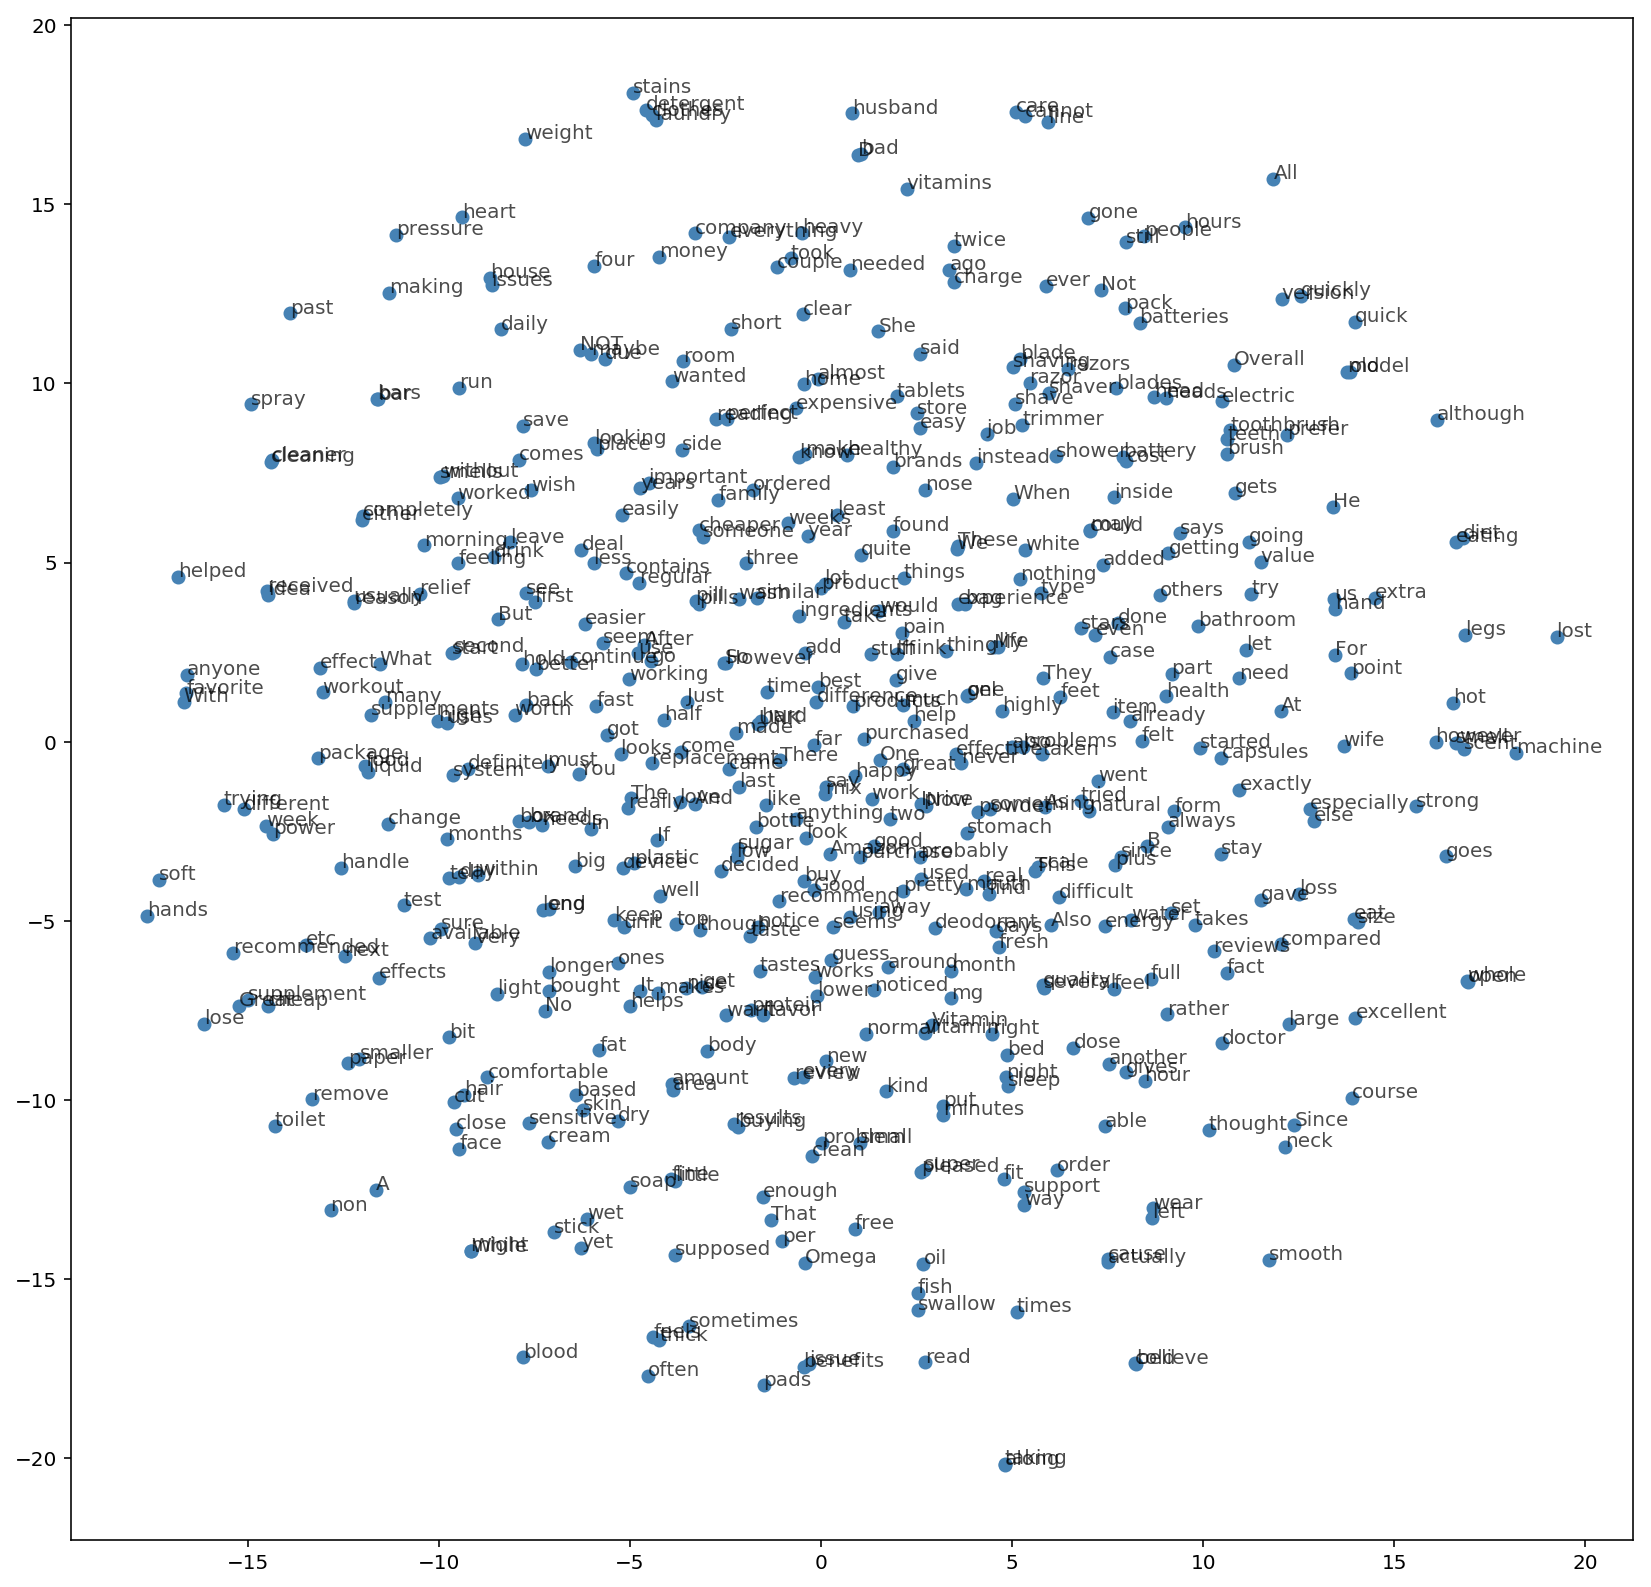

In [26]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)